In [1]:
import nltk 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
!pip install contractions
import contractions 
import string

In [2]:
pd.set_option('display.max_colwidth',100)
# Load training set 
raw_ = pd.read_csv('text-data/train.csv')
raw_.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAf...,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [3]:
raw_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# split data into training and test 
X_train, X_test, y_train, y_test = train_test_split(raw_[['text']],raw_['target'],random_state=42)
print(X_train.shape, X_test.shape)
X_train[50:70]

(5709, 1) (1904, 1)


,text
1934,Next May I'll be free...from school from obligations like family.... Best of all that damn curfe...
5345,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu
6359,NTSB: Virgin Galactic crash caused by structural failure triggered when brakes unlocked early ht...
3882,Zouma has just absolutely flattened that guy ??
4756,Don't blink ?? won't see the Lightning take the W ?? http://t.co/D4c2iqiRnU
5062,anyway 2 me? Mateo just doesnt exist? Hes a mirage a pointless addition to our Generation. a hum...
1203,The greatest female beat boxer ever now but it's w/e... Save babies outta burning buildings on m...
2550,If Shantae doesn't get in Smash I will destroy my Wii U.\n#ShantaeForSmash #Shantae #ShantaeHalf...
969,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/...
1805,Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa


In [5]:
# Exploring what the unique keywords and locations are 
non_null_kw = raw_.keyword.notnull()
non_null_loc = raw_.location.notnull()
raw_['keyword'][non_null_kw].unique()[:30]

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags'], dtype=object)

In [6]:
raw_['location'][non_null_loc].unique()[:30]

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA'], dtype=object)

#### Feature creation and evaluation 
Its worthwhile thinking about what kind of features could be useful in better predicting disasters. 

In [7]:
from nltk.tokenize import punkt 
from nltk import word_tokenize 
from nltk.corpus import stopwords 

# create a data cleaning function that tokenizes, 
# removes english stopwords and punctuations and returns tokenized text in lowercase 

eng_stop = stopwords.words('english') # english stopwords
wn = nltk.WordNetLemmatizer() # Instantiate word lemmatizer

def clean_text_lm(text):
    '''Removes punctuations and stopwords and returns lowercase tokenized text for input text and pattern'''
    # expand contracted sentences
    doc = contractions.fix(text) 
    
    # match regex pattern and replace with empty string
#     doc_nousr = re.sub(r'@[^\s]+',r'',doc)
    doc_nourl = re.sub(r'(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',r'',doc)
    doc_nospchar = re.sub(r'^a-zA-Z\s\W+',r'',doc_nourl,re.I | re.A) 
    
    # remove punctuations from previous out
    doc_nopunct = ''.join([char for char in doc_nospchar if char not in string.punctuation])
    
    # convert text to lower case and strip white space if any
    doc_lower_nospc = doc_nopunct.lower().strip() 
    
    # lemmatize and store in list format
    lem_text = [wn.lemmatize(word) for word in re.split('\W+',doc_lower_nospc)] 
    
     # join list into string with no stopwords
    no_stop_docs = ' '.join([word for word in lem_text if word not in eng_stop])
    
    return no_stop_docs
    
    

In [8]:
# Vectorize the function to apply accross dataframe
cleaner = np.vectorize(clean_text_lm)
# store values in separate column in df
X_train['cleaned_text'] = cleaner(X_train[['text']])
X_train[50:70]


,text,cleaned_text
1934,Next May I'll be free...from school from obligations like family.... Best of all that damn curfe...,next may school obligation like best damn
5345,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu,pandemonium aba woman delivers baby without face photo
6359,NTSB: Virgin Galactic crash caused by structural failure triggered when brakes unlocked early ht...,ntsb virgin galactic crash caused structural failure triggered brake unlocked early
3882,Zouma has just absolutely flattened that guy ??,zouma ha absolutely flattened guy
4756,Don't blink ?? won't see the Lightning take the W ?? http://t.co/D4c2iqiRnU,blink see lightning take w
5062,anyway 2 me? Mateo just doesnt exist? Hes a mirage a pointless addition to our Generation. a hum...,anyway 2 mateo doe exist mirage pointless addition generation human natural disaster sorry true
1203,The greatest female beat boxer ever now but it's w/e... Save babies outta burning buildings on m...,greatest female beat boxer ever save baby outta burning building free time ya
2550,If Shantae doesn't get in Smash I will destroy my Wii U.\n#ShantaeForSmash #Shantae #ShantaeHalf...,shantae doe get smash destroy wii shantaeforsmash shantae shantaehalfgeniehero nintendo
969,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/...,new lady shoulder tote handbag faux leather hobo purse cross body bag woman
1805,Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa,police respond crash find suspected heroin


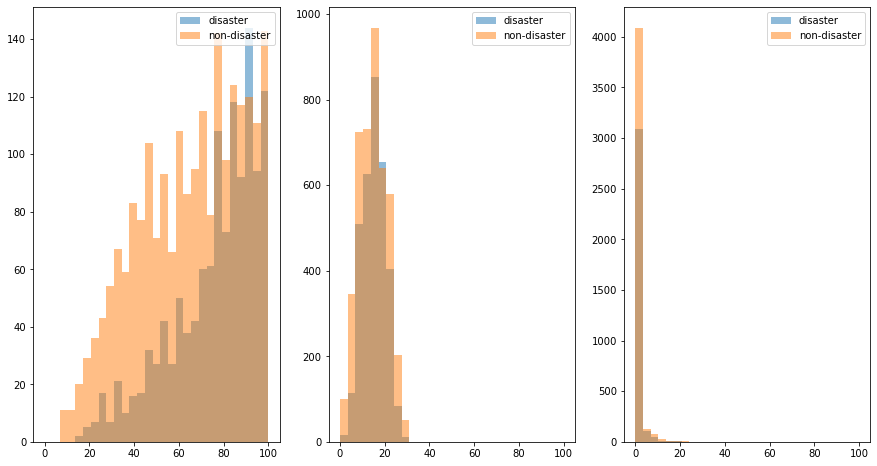

In [31]:
# Length of text 
raw_['doc_len'] = raw_['text'].apply(len)
raw_['word_count'] = raw_['text'].apply(lambda x: len(x.split()))
# Number of caps per tweet 
raw_['CAPS_len'] = raw_['text'].apply(lambda x: 
                                   len([word for word in x.split() if word.isupper()])
                                  )

bins = np.linspace(0, 100, 30)
features_ = raw_.columns 
targets_ = y_train.unique()

fig, ax = plt.subplots(1,3, figsize=(15,8))
# plt.subplot(1,3,1) # 1 line, 2 rows, index nr 1 (first position in the subplot)
ax[0].hist(raw_[raw_['target']==1]['doc_len'], bins, alpha=0.5, label='disaster')
ax[0].hist(raw_[raw_['target']==0]['doc_len'], bins, alpha=0.5, label='non-disaster')
ax[0].legend(loc='upper right')
# plt.subplot(1, 3, 2) 
ax[1].hist(raw_[raw_['target']==1]['word_count'], bins, alpha=0.5, label='disaster')
ax[1].hist(raw_[raw_['target']==0]['word_count'], bins, alpha=0.5, label='non-disaster')
ax[1].legend(loc='upper right')
# plt.subplot(1,3,3)
ax[2].hist(raw_[raw_['target']==1]['CAPS_len'], bins, alpha=0.5, label='disaster')
ax[2].hist(raw_[raw_['target']==0]['CAPS_len'], bins, alpha=0.5, label='non-disaster')
ax[2].legend(loc='upper right')
plt.show()

The cleaned text is now devoid of any special characters or stopwords, however its still not ready to be vectorized. The first action required is to tokenize the words, ie, converting the sentence into a list of words, and then, there can be many words that have a similar meaning such search, searching, searched, etc. I used a lemmatizer (WordNetLemmatizer) to correlate words with similar meaning and keeps the root words. 

In [ ]:
# transform test set to vectorized format
X_test['cleaned_text'] = cleaner(X_test[['text']])
X_test.head()

In [ ]:
# Instantiate CountVectorizer
CountVec = CountVectorizer(analyzer = 'word',ngram_range = (1,1))
# convert text to matrix of token counts
train_cmatrix = CountVec.fit_transform(X_train['cleaned_text']).toarray()
# convert count matrix to dataframe
train_cmatrix_df = pd.DataFrame(train_cmatrix, columns = CountVec.get_feature_names() )

# performing similar steps on test data
test_cmatrix = CountVec.transform(X_test['cleaned_text']).toarray()
test_cmatrix_df = pd.DataFrame(test_cmatrix,columns = CountVec.get_feature_names())


In [ ]:
# Instantiate classifier
rf_clf = RandomForestClassifier(n_jobs=-1)
# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat))
print(confusion_)

#### Hyperparameter tuning 
While the performance using default parameters of the classifier yielded decent scoring in precision, recall and f1-score, we should try to see what would be configuration would provide the best score possible using the RandomForest classifier. To do this, we will use grid search cross validation to determine these parameters. 

In [ ]:
# Find best params
params = {'criterion':['gini','entropy'],
          'n_estimators':[50,100,150], 
          'max_depth':[20,50,75,100,None]
         }
rf = RandomForestClassifier()
gs = GridSearchCV(rf ,param_grid = params ,cv = 5, scoring='f1_score', n_jobs=-1)
gs.fit(train_cmatrix,y_train)
grid_pred = gs.predict(test_cmatrix)
best_params = gs.best_params_
print("Best params: {}\n Best Score: {}".format(best_params,gs.best_score_))
print(classification_report(y_test,grid_pred))


In [ ]:
# Randomizedgridsearch

# Bayesianoptimization 


In [ ]:
# Rerun RF classifier with optimized parameters
rf_clf = RandomForestClassifier(max_depth = best_params['max_depth'], 
                                n_estimators = best_params['n_estimators'], 
                                n_jobs = -1
                               )
# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat))
print(confusion_)

##### Analysis of results
Our optimized model was able to distinguish disaster from non-disaster tweets with ~<b>77%</b> accuracy.
<br>
From the confusion matrix, there seems to be a marked difference in the classification of true negatives and positives. However, we also see any improvements in the precision, recall or f1-scores when compared to the default model. We also notice a drastic difference in recall scores between the 0 (non-disaster) and 1 (disaster) labels. One reason might because of the class imbalance in the training dataset. 
<br>
It might be worthwhile to look into other classifiers as well as adding features to improve our classification. 


#### Using TF-IDF vectorizer and XGB classifier 


In [16]:
tf_vect = TfidfVectorizer(analyzer=clean_text_lm)
train_tfidf_matrix = tf_vect.fit_transform(X_train['text']) 

gb = GradientBoostingClassifier()
